# Análise de Séries Históricas de Tarifas Aéreas 

#### Frederico Horst

Fontes dos Dados:
- Séries históricas de tarifas aéreas, por origem, destino e empresa: disponível no site da ANAC em:
https://sistemas.anac.gov.br/sas/downloads/view/frmDownload.aspx
- Série histórica do IPCA: disponível no site do IBGE em:
https://www.ibge.gov.br/estatisticas/economicas/precos-e-custos/9256-indice-nacional-de-precos-ao-consumidor-amplo.html?=&t=series-historicas

Mais informações sobre o tarifário:
https://www.anac.gov.br/assuntos/dados-e-estatisticas/mercado-do-transporte-aereo

Objetivo:
- Construir o intervalo de confiança da média de preços praticados por trecho. 
- O intervalo de confiança deve ser de 95% de confiança.
- O intervalo será por trecho, independente da companhia aérea. A ideia, primeiramente, é ver sob a ótica do consumidor.



In [30]:
# importando libs necessárias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import basic_statistics as sts



### Importando as séries de dados:

In [2]:
# importando o dicionário de dados dos aeroportos:
aeroportos = pd.read_csv('aeroportos.csv',';')


In [4]:

# tarifas para entre as cidades: São Paulo, Brasília, Rio de Janeiro, Porto Alegre e Curitiba
cidades = ['São Paulo', 'Rio de Janeiro'] #, 'Brasília', 'Porto Alegre', 'Curitiba']
aeroportos_selecionados = aeroportos[aeroportos['Cidade'].isin(cidades)]

# importando as séries de tarifas aéreas já ajustadas:
path = 'tarifas_df_ajustada/'
files = os.listdir(path)

files_list = []

for file in files:
    files_list.append(file)

import_data = []

for file in files_list:
    temp_df = pd.read_csv(path+file, ',')
    # filtrando apenas as cidades selecionadas:
    temp_df = temp_df[temp_df['ORIGEM'].isin(aeroportos_selecionados.ICAO)]
    temp_df = temp_df[temp_df['DESTINO'].isin(aeroportos_selecionados.ICAO)]
    # ajustando campo do período para string
    temp_df['PERIODO'] = temp_df.PERIODO.astype(str)
    import_data.append(temp_df)
    temp_df = None


In [6]:
print(type(import_data))

<class 'list'>


In [7]:
# problema -- otimizar o código
tarifas_df = pd.concat(import_data)

tarifas_df.tail()

,Unnamed: 0,ANO,MES,EMPRESA,ORIGEM,DESTINO,TARIFA,ASSENTOS,PERIODO
1284011,178,2003,3,GLO,SBSP,SBGL,160.43,596,200303
1284012,178,2003,3,GLO,SBSP,SBGL,160.43,596,200303
1284013,178,2003,3,GLO,SBSP,SBGL,160.43,596,200303
1284014,178,2003,3,GLO,SBSP,SBGL,160.43,596,200303
1284015,178,2003,3,GLO,SBSP,SBGL,160.43,596,200303


In [8]:
empresas = tarifas_df['EMPRESA'].unique()
origens = tarifas_df['ORIGEM'].unique()
destinos = tarifas_df['DESTINO'].unique()

In [10]:
print(destinos, origens)

['SBSP' 'SBRJ' 'SBGL'] ['SBRJ' 'SBSP' 'SBGL']


### Criando Dataframe com as Estatísticas

In [20]:

tarifas_count = tarifas_df.copy()
tarifas_count = tarifas_count.groupby(['ANO','MES','PERIODO','ORIGEM','DESTINO']).count().reset_index()
tarifas_count = tarifas_count[['ANO','MES','PERIODO','ORIGEM','DESTINO','TARIFA']]
tarifas_count.columns = ['ANO','MES','PERIODO','ORIGEM','DESTINO','FREQUÊNCIA']

tarifas_sts = tarifas_df.copy()
tarifas_sts = tarifas_sts.groupby(['ANO','MES','PERIODO','ORIGEM','DESTINO']).mean().reset_index()
tarifas_sts = tarifas_sts[['ANO','MES','PERIODO','ORIGEM','DESTINO','TARIFA']]
tarifas_sts.columns = ['ANO','MES','PERIODO','ORIGEM','DESTINO','TARIFA MÉDIA']
tarifas_sts = pd.merge(tarifas_sts,tarifas_count, how = 'left', on = ['ANO','MES','PERIODO','ORIGEM','DESTINO'])
tarifas_count = None
tarifas_sts.head()

,ANO,MES,PERIODO,ORIGEM,DESTINO,TARIFA MÉDIA,FREQUÊNCIA
0,2002,1,200201,SBGL,SBSP,114.777877,14920
1,2002,1,200201,SBRJ,SBSP,202.132177,85690
2,2002,1,200201,SBSP,SBGL,113.439955,13197
3,2002,1,200201,SBSP,SBRJ,203.266519,82375
4,2002,2,200202,SBGL,SBSP,112.784747,13635


In [27]:
# criando listas de dados para colocar no dataframe
tarifa_media_percentil_025 = []
tarifa_media_percentil_500 = []
tarifa_media_percentil_975 = []

In [36]:
for origem in origens:
    for destino in destinos:
        print(origem, destino)
        try:
            df = tarifas_df[tarifas_df['ORIGEM'] == origem].copy()
            df = df[df['DESTINO'] == destino]
            ic_tarifa_media = sts.draw_bs_reps(df.TARIFA, np.mean, size = 100)
            tarifa_media_percentil_025.append(ic_tarifa_media, 2.5)
            tarifa_media_percentil_975.append(ic_tarifa_media, 97.5)
            tarifa_media_percentil_500.append(ic_tarifa_media, 50) # mediana
            df = None
            print('ok')
        except Exception as erro:
            print('ERRO: ')
            print(erro)


SBRJ SBSP


KeyboardInterrupt: 

In [26]:
tarifas_sts['TARIFA MÉDIA - PERCENTIL 2,5'] = tarifa_media_percentil_025
tarifas_sts['TARIFA MÉDIA - PERCENTIL 50'] = tarifa_media_percentil_500
tarifas_sts['TARIFA MÉDIA - PERCENTIL 97,5'] = tarifa_media_percentil_975


tarifas_sts.head()

### Gráficos 

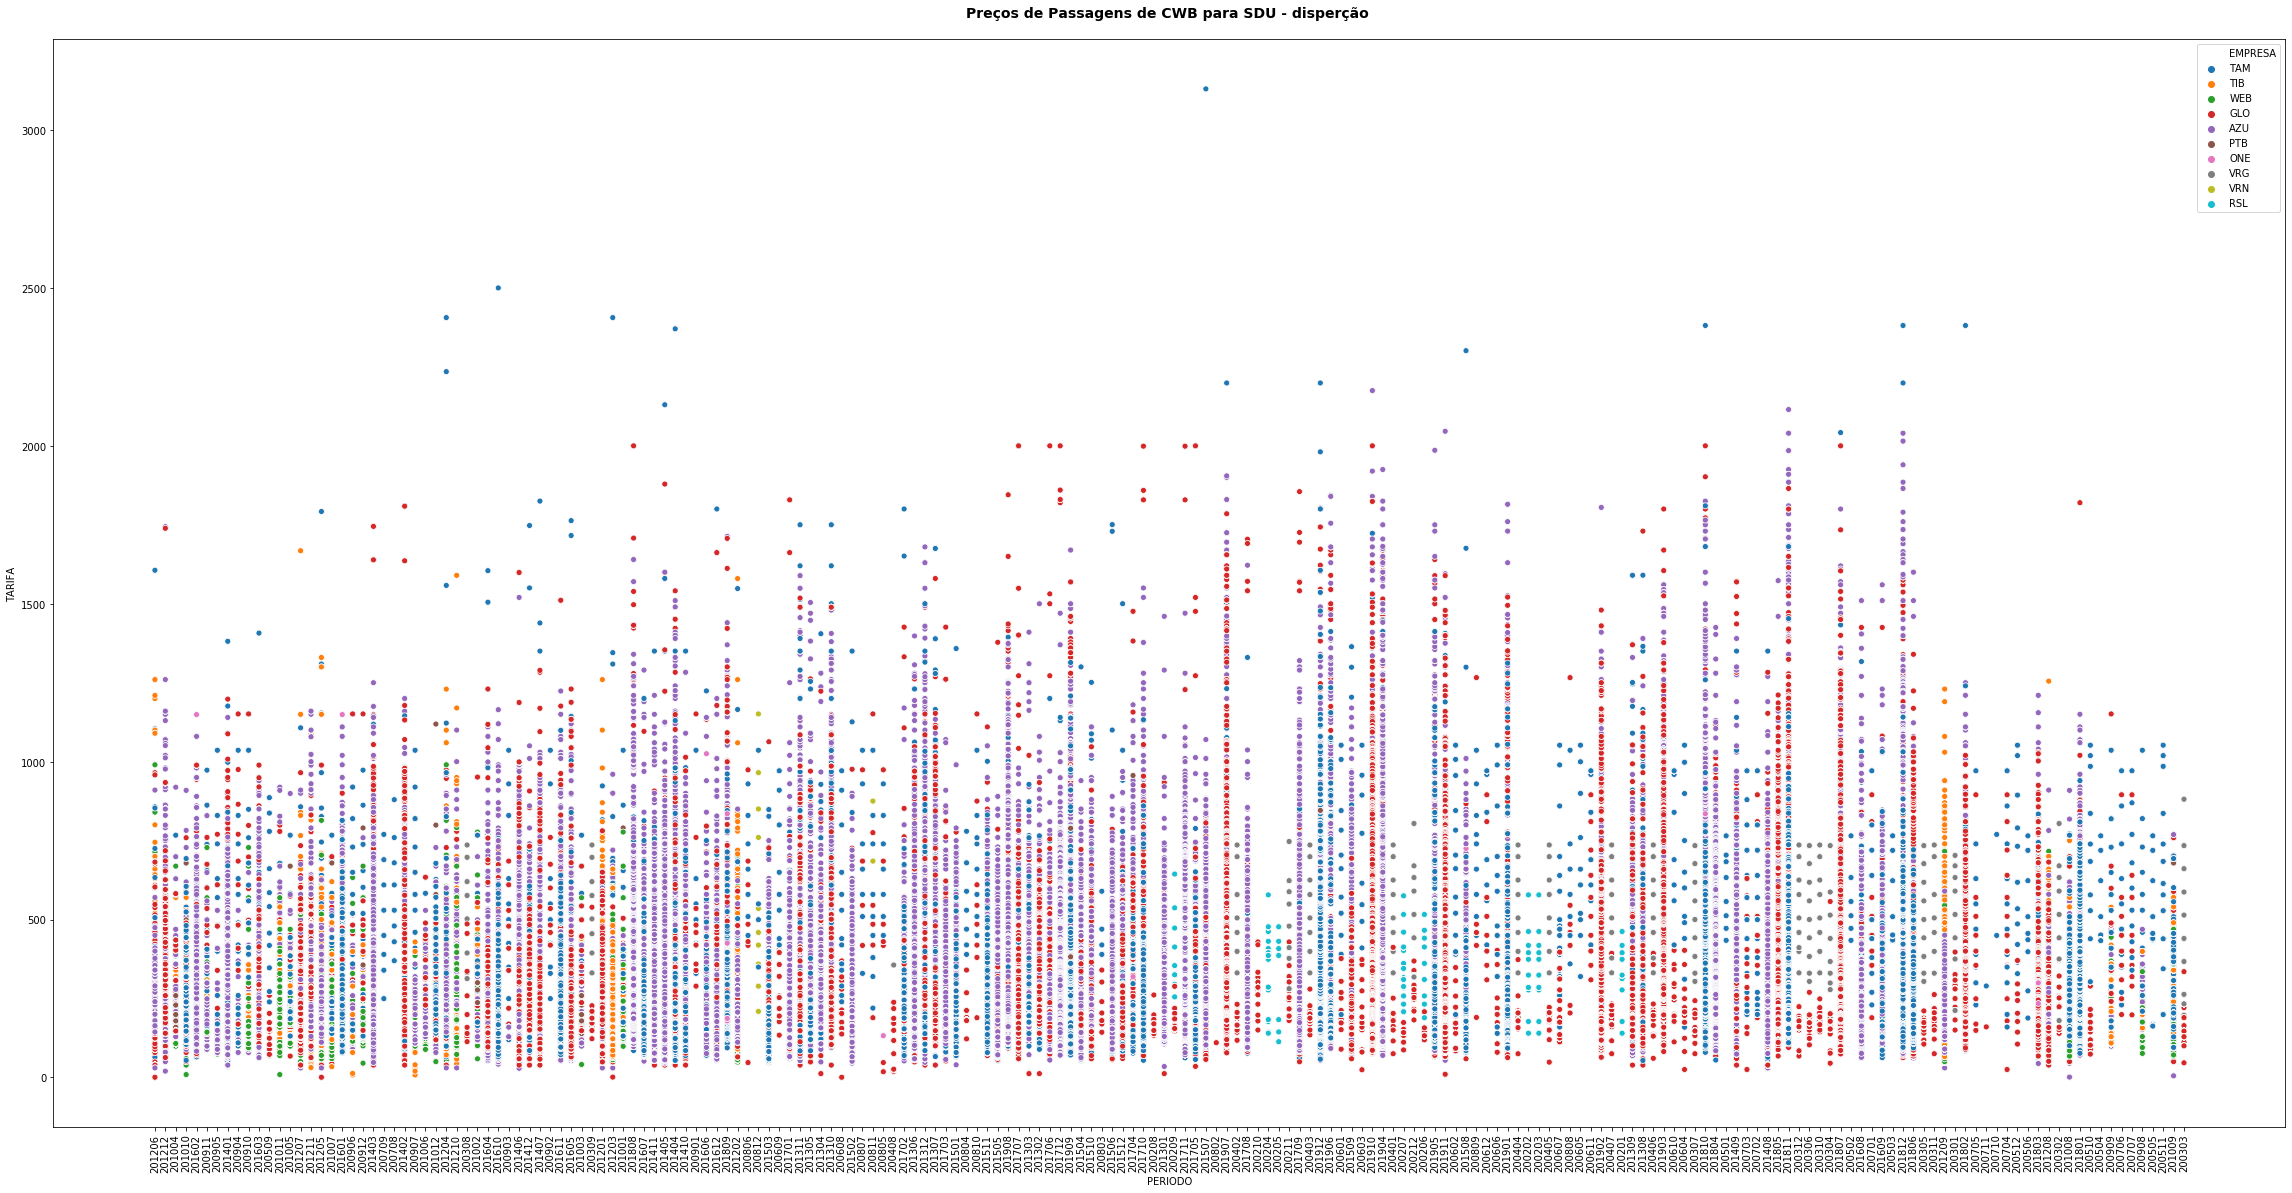

In [20]:
# gráfico

df_teste = tarifas_df[tarifas_df['ORIGEM']=='SBCT'].copy()
df_teste = df_teste[df_teste['DESTINO']=='SBRJ']
# df_teste_st = df_teste.groupby(['PERIODO','EMPRESA']).mean().reset_index()[['PERIODO','EMPRESA','TARIFA']]

f = plt.figure(figsize=(40,20))

f = sns.scatterplot(x='PERIODO', y='TARIFA',
             hue='EMPRESA',# style="event",
             data=df_teste)

f = plt.xticks(rotation=90)

f = plt.title('Preços de Passagens de CWB para SDU - disperção \n', fontweight='bold', fontsize=14)

plt.savefig('dispercao-cwb-sdu.png')

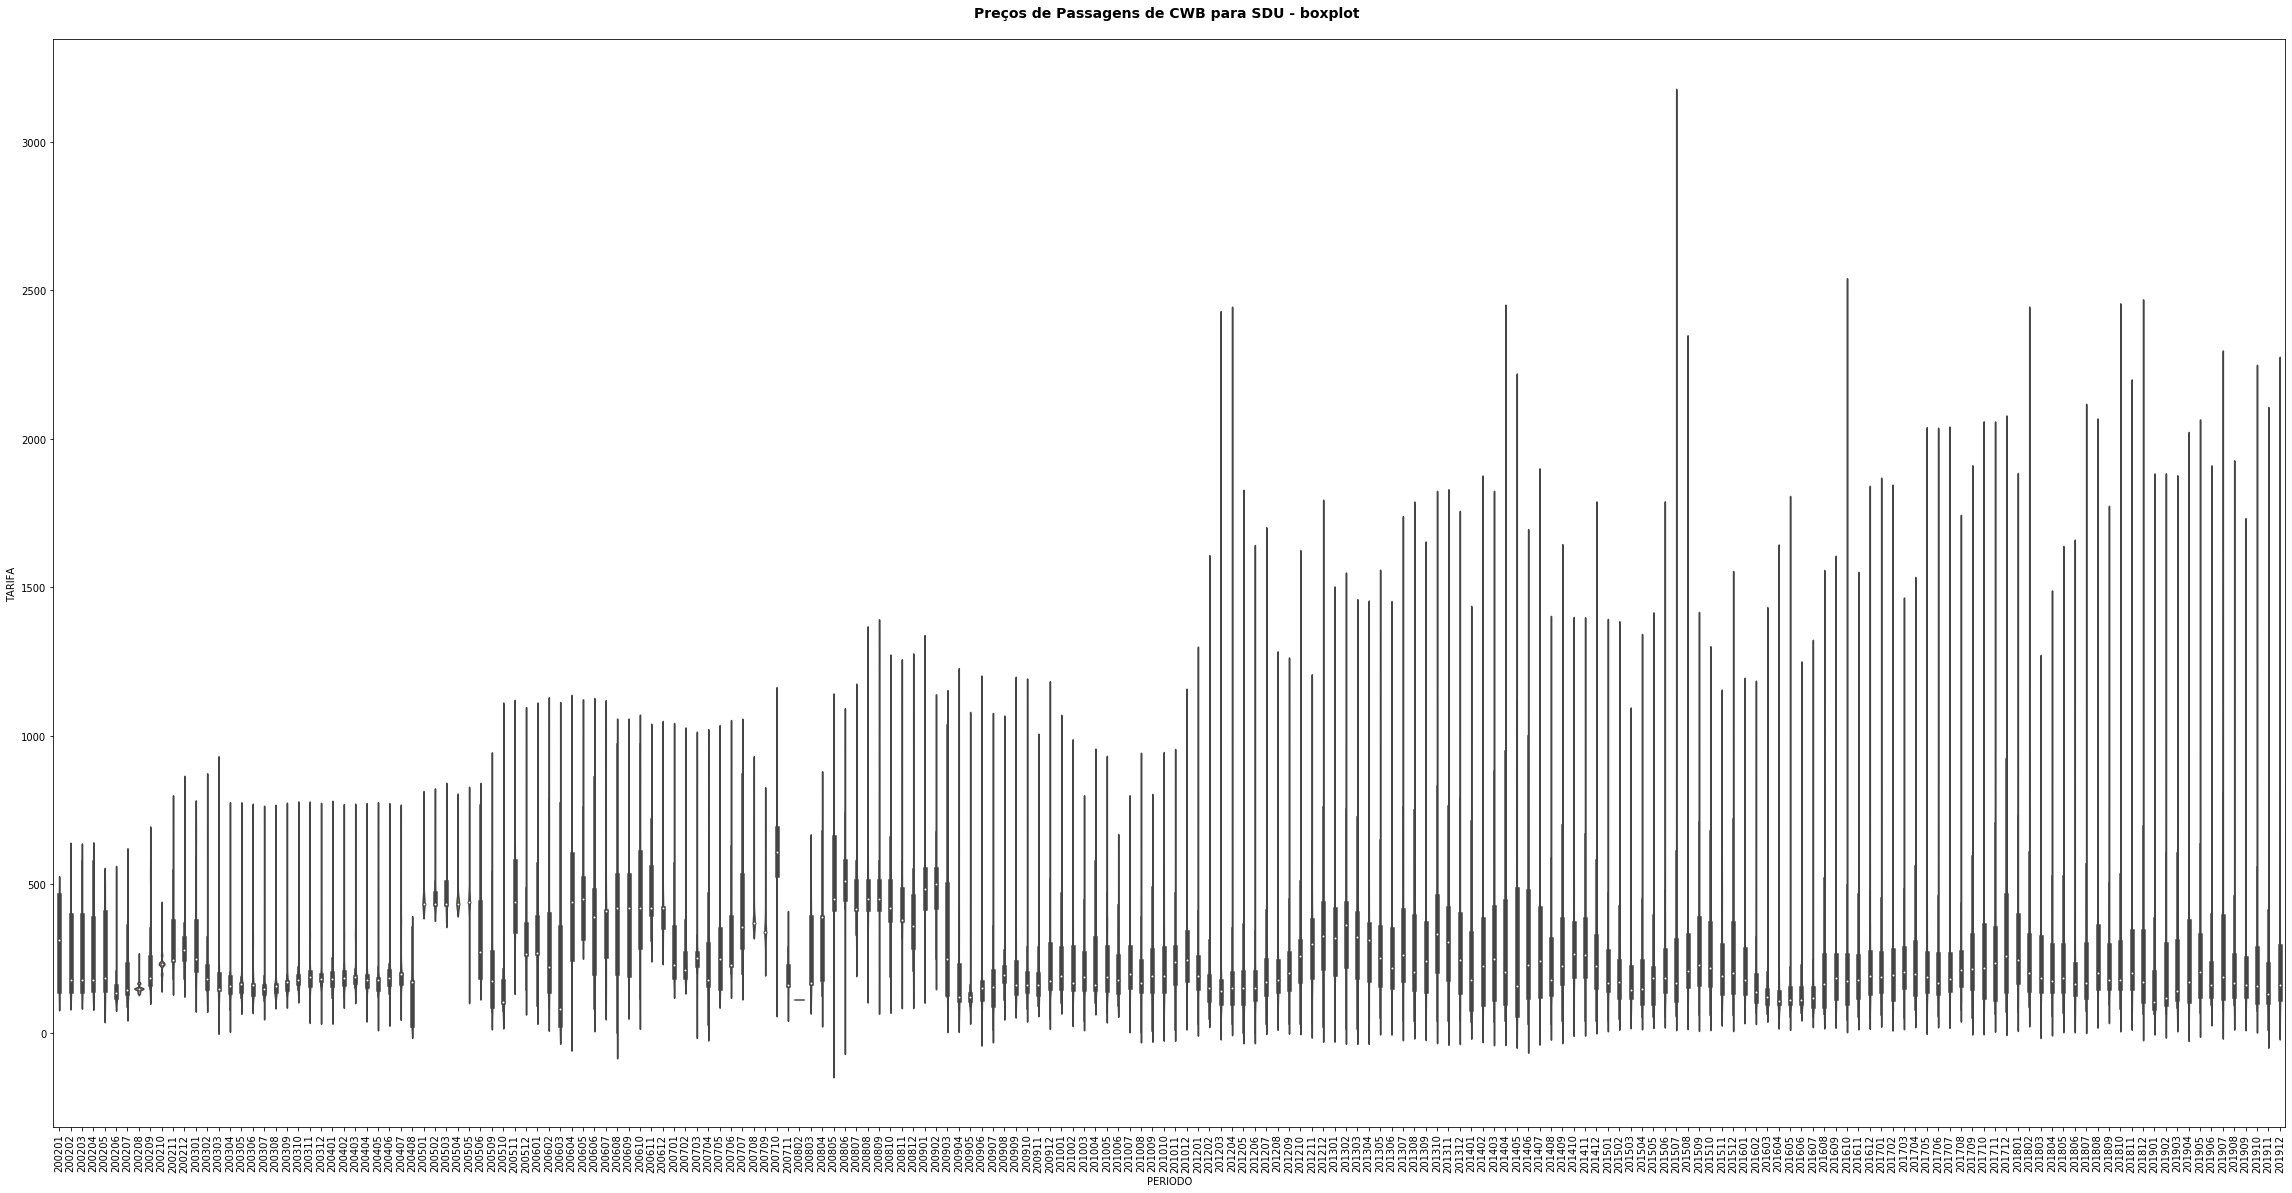

In [22]:
# gráfico violino

f = plt.figure(figsize=(40,20))

f = sns.violinplot(x='PERIODO', y='TARIFA',
             data=df_teste)

f = plt.xticks(rotation=90)

f = plt.title('Preços de Passagens de CWB para SDU - boxplot \n', fontweight='bold', fontsize=14)

plt.savefig('boxplot-cwb-sdu.png')


In [ ]:
# 
# for origem in origens:
#     for destino in destinos:
#         print(origem, destino)
# tarifas_df.describe()
# print(type(tarifas_df['PERIODO']))

In [ ]:
# # tipo_cadastro = ['Abertura', 'Migração']

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7), sharey=True, sharex=True)
# # f, (ax1, ax2) = plt.subplots(figsize=(12,12))

# f = ax1.hist(df_base_inativos['tempo_em_meses_como_cliente'][df_base_inativos['tipo_cadastro'] == 'Abertura'], bins = 30)
# f = ax1.set_title('Clientes de Abertura que Cancelaram', fontweight='bold',fontsize=14)
# f = ax1.set_xlabel('Tempo em meses em que o cliente ficou ativo')
# f = ax2.hist(df_base_inativos['tempo_em_meses_como_cliente'][df_base_inativos['tipo_cadastro'] == 'Migração'], bins = 30)
# f = ax2.set_title('Clientes de Migração que Cancelaram', fontweight='bold',fontsize=14)
# f = ax2.set_xlabel('Tempo em meses em que o cliente ficou ativo')

# plt.show()

In [ ]:


# f, axes = plt.subplots(2, 2, figsize=(14,14), sharey=True, sharex=True)
# # f, (ax1, ax2) = plt.subplots(figsize=(12,12))

# f = axes[0,0].hist(df_base_inativos['tempo_em_meses_como_cliente'][df_base_inativos['cidade'] == 'São Paulo'], bins = 30)
# f = axes[0,0].set_title('Clientes de São Paulo que Cancelaram', fontweight='bold',fontsize=14)
# f = axes[0,0].set_xlabel('Tempo em meses em que o cliente ficou ativo')
# f = axes[0,1].hist(df_base_inativos['tempo_em_meses_como_cliente'][df_base_inativos['cidade'] == 'Rio de Janeiro'], bins = 30)
# f = axes[0,1].set_title('Clientes do Rio de Janeiro que Cancelaram', fontweight='bold',fontsize=14)
# f = axes[0,1].set_xlabel('Tempo em meses em que o cliente ficou ativo')
# f = axes[1,0].hist(df_base_inativos['tempo_em_meses_como_cliente'][df_base_inativos['cidade'] == 'Curitiba'], bins = 30)
# f = axes[1,0].set_title('Clientes de Curitiba que Cancelaram', fontweight='bold',fontsize=14)
# f = axes[1,0].set_xlabel('Tempo em meses em que o cliente ficou ativo')
# f = axes[1,1].hist(df_base_inativos['tempo_em_meses_como_cliente'][df_base_inativos['cidade'] == 'Demais Cidades'], bins = 30)
# f = axes[1,1].set_title('Clientes das Demais Cidades que Cancelaram', fontweight='bold',fontsize=14)
# f = axes[1,1].set_xlabel('Tempo em meses em que o cliente ficou ativo')

# plt.show()
